In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTENC

In [2]:
df = pd.read_csv("../cleaned_hate_crime.csv")

In [3]:
df.head()

,region_name,offender_race,grouped_total_offender_count,grouped_victim_count,generalized_offense_name,generalized_location_name,generalized_bias_desc
0,Midwest,White,Few,Few,violent crimes,Residence,race
1,Northeast,White,Few,Few,violent crimes,Miscellaneous,race
2,Northeast,White,Few,Few,violent crimes,Miscellaneous,race
3,South,Black or African American,Several,Few,violent crimes,Public Place,race
4,Northeast,Black or African American,Few,Few,violent crimes,Miscellaneous,race


In [4]:
# Creating X and Y General Subsets of the data
X_xgb = df[["region_name", "offender_race", "grouped_total_offender_count", "grouped_victim_count", "generalized_offense_name", "generalized_location_name"]]

Y_xgb = df["generalized_bias_desc"]

- 0:Race
- 1:Region
- 2:Sexual Orientation

<Axes: xlabel='generalized_bias_desc', ylabel='count'>

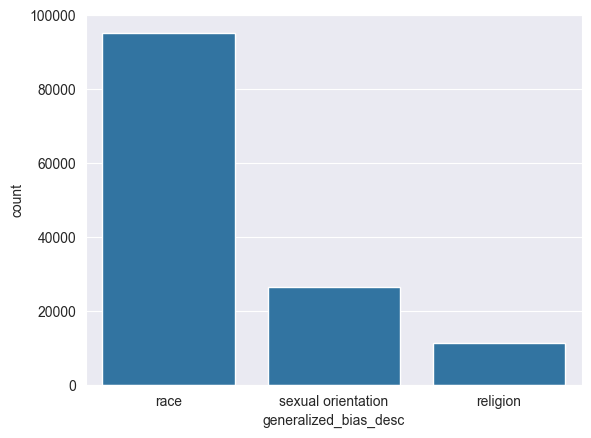

In [5]:
order = Y_xgb.value_counts().index

sns.countplot(x=Y_xgb, order=order)

In [6]:
cat_vars=["region_name", "offender_race", "grouped_total_offender_count", "grouped_victim_count", "generalized_offense_name", "generalized_location_name"]

for var in cat_vars:
    cat_list = pd.get_dummies(X_xgb[var], prefix=var)
    X_xgb = pd.concat([X_xgb, cat_list], axis=1)
    X_xgb.drop(var, axis=1, inplace=True)

In [7]:
X_xgb.head()

,region_name_Midwest,region_name_Northeast,region_name_Other,region_name_South,region_name_U.S. Territories,region_name_West,offender_race_American Indian or Alaska Native,offender_race_Asian,offender_race_Black or African American,offender_race_Multiple,...,generalized_offense_name_sexual crimes,generalized_offense_name_violent crimes,generalized_location_name_Construction/Industrial,generalized_location_name_Education,generalized_location_name_Law Enforcement,generalized_location_name_Miscellaneous,generalized_location_name_Outdoor/Nature,generalized_location_name_Public Place,generalized_location_name_Residence,generalized_location_name_Retail
0,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
1,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
3,False,False,False,True,False,False,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False
4,False,True,False,False,False,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False


In [8]:
# encode the generalized bias description to 0, 1,2
Y_xgb = Y_xgb.replace("race", 0)
Y_xgb = Y_xgb.replace("religion", 1)
Y_xgb = Y_xgb.replace("sexual orientation", 2)

In [9]:
# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_xgb, Y_xgb, test_size=0.2, random_state=69)

## Applying SMOTENC

In [10]:
cat_indices = [0, 1, 2]

# Apply SMOTENC
smote_nc = SMOTENC(categorical_features=cat_indices, random_state=69)

# Splitting the data into training and testing sets
X_train_resampled, Y_train_resampled  = smote_nc.fit_resample(X_train, Y_train)

<Axes: xlabel='generalized_bias_desc', ylabel='count'>

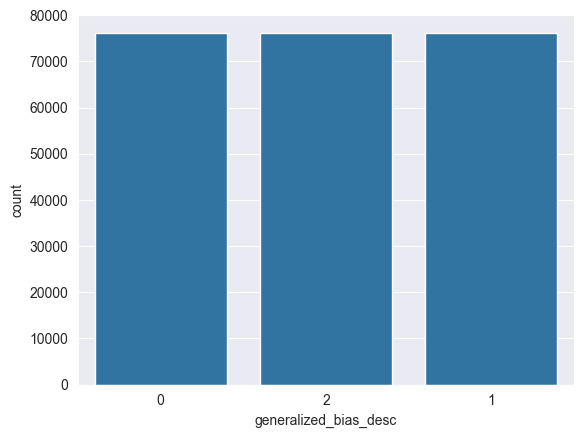

In [11]:
order_2 = Y_train_resampled.value_counts().index

sns.countplot(x=Y_train_resampled, order=order_2)

In [12]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", num_class=3, max_depth=10, random_state=69)

xgb_model.fit(X_train_resampled, Y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [13]:
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
print("Accruacy:", accuracy)

Accruacy: 0.4351830964734191


In [14]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.42      0.54     19004
           1       0.17      0.49      0.26      2310
           2       0.26      0.48      0.33      5284

    accuracy                           0.44     26598
   macro avg       0.40      0.46      0.38     26598
weighted avg       0.62      0.44      0.48     26598



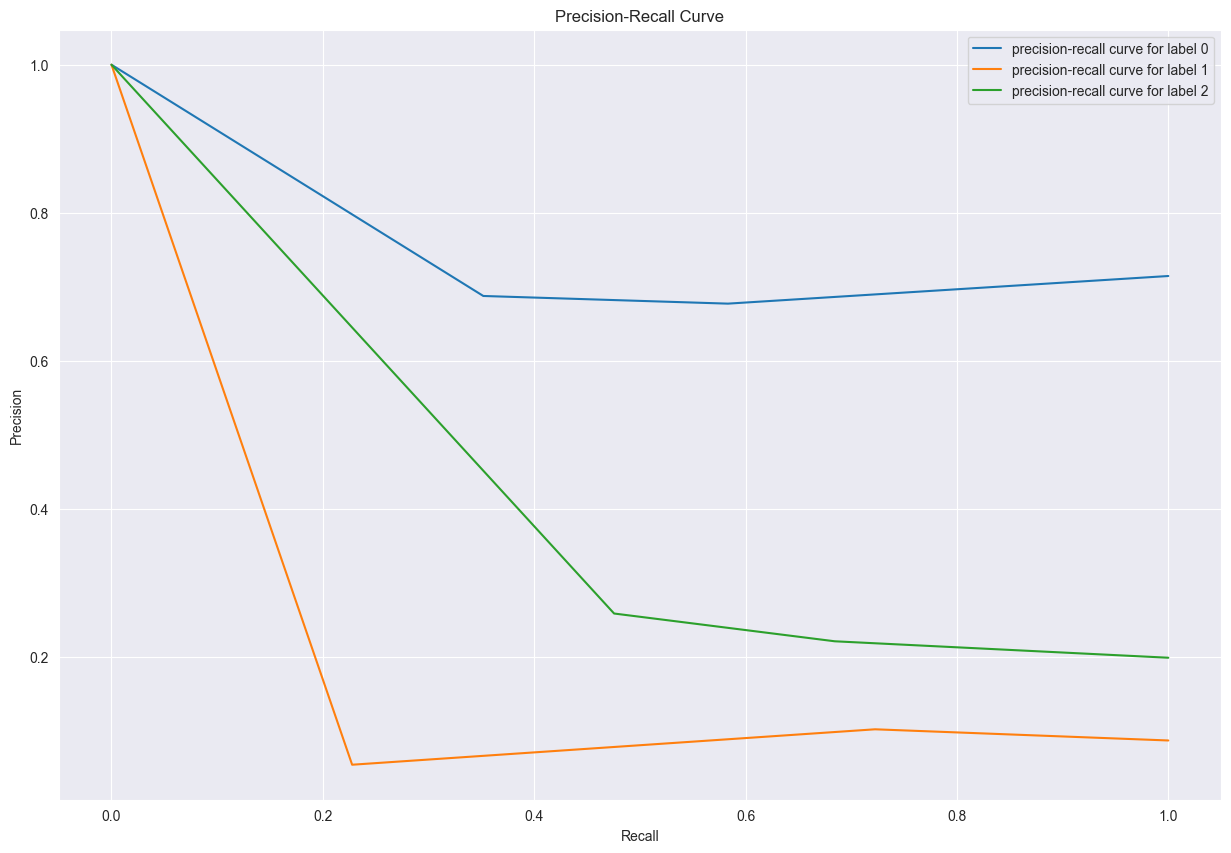

In [15]:
# precision recall curve
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()

precision0, recall0, _ = precision_recall_curve(Y_test, y_pred, pos_label=0)
precision1, recall1, _ = precision_recall_curve(Y_test, y_pred, pos_label=1)
precision2, recall2, _ = precision_recall_curve(Y_test, y_pred, pos_label=2)

plt.figure(figsize=(15, 10))
plt.plot(recall0, precision0, label='precision-recall curve for label 0')
plt.plot(recall1, precision1, label='precision-recall curve for label 1')
plt.plot(recall2, precision2, label='precision-recall curve for label 2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.show()